### Importing Libraries

In [343]:
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from urllib.parse import urlparse
from wordcloud import WordCloud
import re

In [58]:
main = pd.read_csv("malicious_phish.csv")
main

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,www.gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


In [59]:
file_paths = [
    ("FinalDataset/URL/Benign_list_big_final.csv", "benign"),
    ("FinalDataset/URL/DefacementSitesURLFiltered.csv", "defacement"),
    ("FinalDataset/URL/Malware_dataset.csv", "malware"),
    ("FinalDataset/URL/phishing_dataset.csv", "phishing"),
    ("FinalDataset/URL/spam_dataset.csv", "spam")
]

# Initialize an empty list to store dataframes
dfs = []

# Iterate through the file paths and types
for file_path, url_type in file_paths:
    # Read the CSV file
    df = pd.read_csv(file_path, header=None)
    # Assign column names
    df.columns = ["url"]
    # Add a column for the URL type
    df["type"] = url_type
    # Append the dataframe to the list
    dfs.append(df)

dfs.append(main)
# Concatenate the list of dataframes into a single dataframe
merged_df = pd.concat(dfs, ignore_index=True)
merged_df.drop_duplicates(inplace=True)
merged_df.reset_index(drop=True, inplace=True)

### Preprocessing

In [63]:
merged_df['type'].unique()

array(['benign', 'defacement', 'malware', 'phishing', 'spam'],
      dtype=object)

Removing Duplicates

In [67]:
missing_values = merged_df.isnull().sum()
print("Missing values:\n", missing_values)
merged_df = merged_df.dropna() 

Missing values:
 url     0
type    0
dtype: int64


In [69]:
merged_df = merged_df.drop_duplicates()

In [71]:
merged_df['url_length'] = merged_df['url'].apply(lambda x: len(str(x)))

Handling Outliers

In [74]:
threshold = merged_df['url_length'].quantile(0.85)
merged_df = merged_df[merged_df['url_length'] <= threshold]
merged_df = merged_df.drop(columns=['url_length'])

Encoding Categorical Variables

In [77]:
label_encoder = LabelEncoder()
merged_df['type_encoded'] = label_encoder.fit_transform(merged_df['type'])
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Encoding Mapping:", label_mapping)

Label Encoding Mapping: {'benign': 0, 'defacement': 1, 'malware': 2, 'phishing': 3, 'spam': 4}


In [205]:
merged_df['type_text'] = merged_df['type'].apply(lambda x: f"This URL is classified as {x}.")
merged_df

,url,type,type_encoded,type_text
0,http://1337x.to/torrent/1048648/American-Snipe...,benign,0,This URL is classified as benign.
1,http://1337x.to/torrent/1110018/Blackhat-2015-...,benign,0,This URL is classified as benign.
2,http://1337x.to/torrent/1122940/Blackhat-2015-...,benign,0,This URL is classified as benign.
3,http://1337x.to/torrent/1124395/Fast-and-Furio...,benign,0,This URL is classified as benign.
4,http://1337x.to/torrent/1145504/Avengers-Age-o...,benign,0,This URL is classified as benign.
...,...,...,...,...
653041,xbox360.ign.com/objects/850/850402.html,phishing,3,This URL is classified as phishing.
653042,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,3,This URL is classified as phishing.
653043,www.gamespot.com/xbox360/action/deadspace/,phishing,3,This URL is classified as phishing.
653044,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,3,This URL is classified as phishing.


### Balancing the Dataset

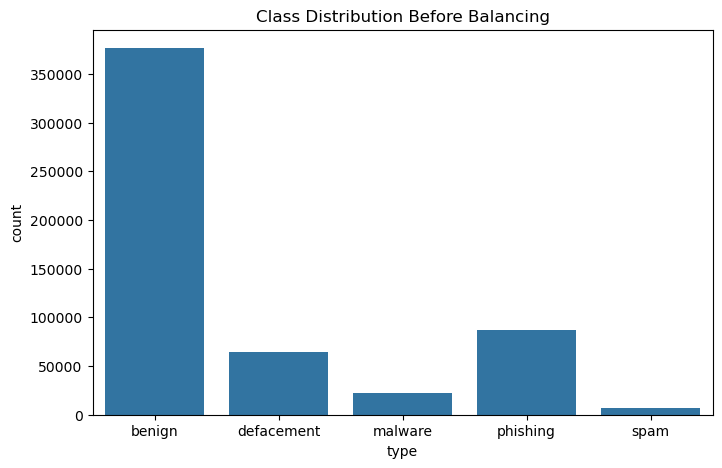

type
benign        376626
phishing       87153
defacement     64726
malware        22608
spam            6569
Name: count, dtype: int64


In [207]:
# Count plot for class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=merged_df['type'])
plt.title("Class Distribution Before Balancing")
plt.show()

# Print value counts
print(merged_df['type'].value_counts())

1. Undersample the benign class 
2. Oversample the minority classes (spam, malware, defacement, phishing) 

In [235]:

X = merged_df[['url']]
y = merged_df['type']

undersample = RandomUnderSampler(sampling_strategy={'benign': 6569, 'spam': 6569, 'malware': 6569,'defacement': 6569,'phishing': 6569}, random_state=42)

X_under, y_under = undersample.fit_resample(X, y)

merged_df_under = pd.DataFrame({'url': X_under['url'], 'type': y_under})


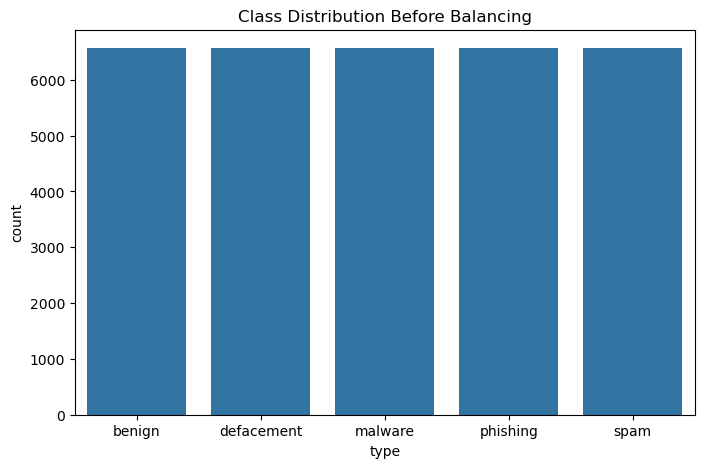

type
benign        6569
defacement    6569
malware       6569
phishing      6569
spam          6569
Name: count, dtype: int64


In [248]:
# Count plot for class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=merged_df_under['type'])
plt.title("Class Distribution Before Balancing")
plt.show()

# Print value counts
print(merged_df_under['type'].value_counts())

### EDA

In [244]:
# Describe Data
merged_df_under.describe()

,url,type
count,32845,32845
unique,32845,5
top,www.tsxzsp.cn/tsspee/OA/leftpic/recadastrament...,benign
freq,1,6569


In [258]:
# Extract domain, subdomains, and path from URLs
merged_df_under["parsed_url"] = merged_df_under["url"].apply(urlparse)
merged_df_under["domain"] = merged_df_under["parsed_url"].apply(lambda x: x.netloc)
merged_df_under["path"] = merged_df_under["parsed_url"].apply(lambda x: x.path)
merged_df_under["subdomains"] = merged_df_under["domain"].apply(lambda x: x.count("."))
merged_df_under["url_length"] = merged_df_under["url"].apply(len)

# Count special characters in URLs
special_chars = [".", "/", "-", "_", "=", "?", "&"]
for char in special_chars:
    merged_df_under[f"count_{char}"] = merged_df_under["url"].apply(lambda x: x.count(char))

# Drop parsed URL column
merged_df_under.drop(columns=["parsed_url"], inplace=True)

# Display updated DataFrame
merged_df_under.head()


,url,type,domain,path,subdomains,url_length,count_.,count_/,count_-,count__,count_=,count_?,count_&
560852,www.tsxzsp.cn/tsspee/OA/leftpic/recadastrament...,benign,,www.tsxzsp.cn/tsspee/OA/leftpic/recadastrament...,0,52,3,4,0,0,0,0,0
375124,ratemds.com/doctor-ratings/3341912/Dr-Serge-Sa...,benign,,ratemds.com/doctor-ratings/3341912/Dr-Serge-Sa...,0,64,2,3,5,0,0,0,0
485454,brainwashed.com/common/htdocs/discog/krank161....,benign,,brainwashed.com/common/htdocs/discog/krank161....,0,50,2,4,0,0,0,0,0
466187,worldhockeyjerseys.com/index.html,benign,,worldhockeyjerseys.com/index.html,0,33,2,1,0,0,0,0,0
332725,bluemarblegameco.com/,benign,,bluemarblegameco.com/,0,21,1,1,0,0,0,0,0


C:\Users\abdul\AppData\Local\Temp\ipykernel_24752\3104318853.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=merged_df_under, x="type", palette="viridis", order=merged_df_under["type"].value_counts().index)


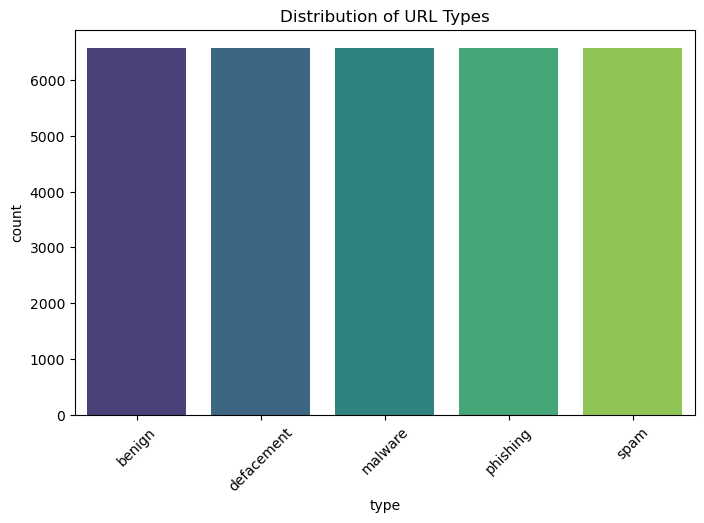

In [260]:
plt.figure(figsize=(8,5))
sns.countplot(data=merged_df_under, x="type", palette="viridis", order=merged_df_under["type"].value_counts().index)
plt.title("Distribution of URL Types")
plt.xticks(rotation=45)
plt.show()


C:\Users\abdul\AppData\Local\Temp\ipykernel_24752\398809453.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="type", y="url_length", data=merged_df_under, palette="coolwarm")


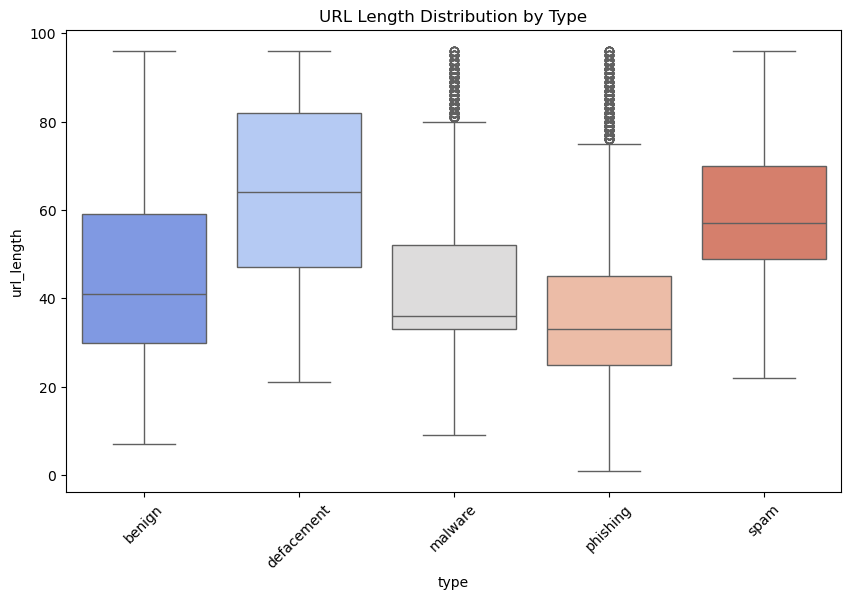

In [262]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="type", y="url_length", data=merged_df_under, palette="coolwarm")
plt.title("URL Length Distribution by Type")
plt.xticks(rotation=45)
plt.show()


<Figure size 1200x600 with 0 Axes>

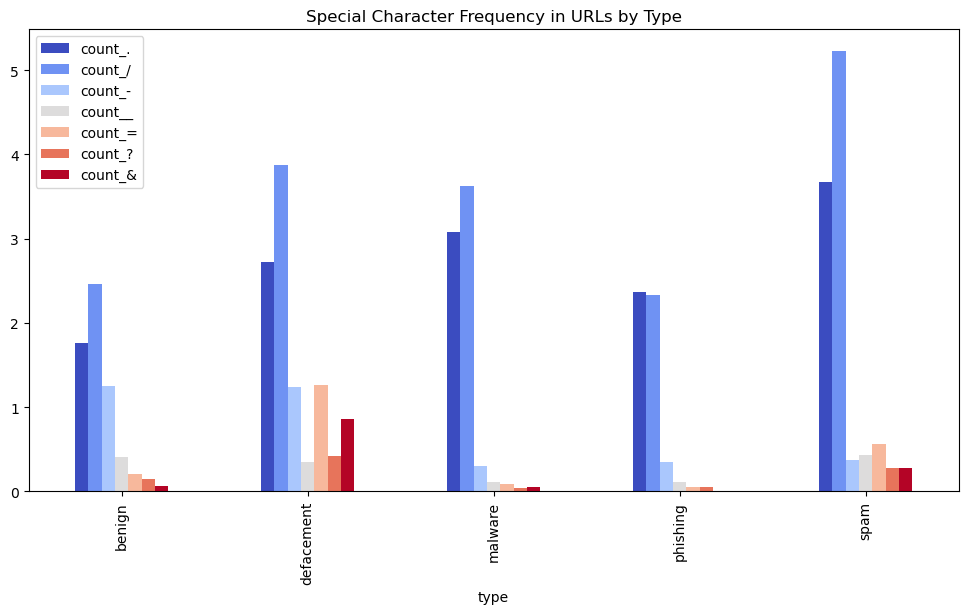

In [264]:
plt.figure(figsize=(12, 6))
char_cols = [f"count_{char}" for char in special_chars]
merged_df_under.groupby("type")[char_cols].mean().plot(kind="bar", figsize=(12,6), colormap="coolwarm")
plt.title("Special Character Frequency in URLs by Type")
plt.show()


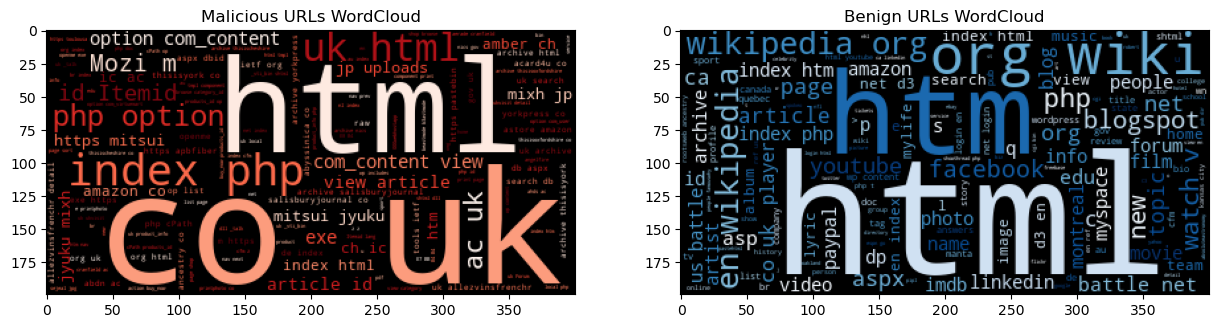

In [274]:
malicious_text = " ".join(merged_df_under[merged_df_under["type"] != "benign"]["url"])
benign_text = " ".join(merged_df_under[merged_df_under["type"] == "benign"]["url"])

fig, ax = plt.subplots(1,2, figsize=(15,7))

ax[0].imshow(WordCloud(background_color="black", colormap="Reds").generate(malicious_text))
ax[0].set_title("Malicious URLs WordCloud")

ax[1].imshow(WordCloud(background_color="black", colormap="Blues").generate(benign_text))
ax[1].set_title("Benign URLs WordCloud")

plt.show()


In [276]:
merged_df_under.head()

,url,type,domain,path,subdomains,url_length,count_.,count_/,count_-,count__,count_=,count_?,count_&
560852,www.tsxzsp.cn/tsspee/OA/leftpic/recadastrament...,benign,,www.tsxzsp.cn/tsspee/OA/leftpic/recadastrament...,0,52,3,4,0,0,0,0,0
375124,ratemds.com/doctor-ratings/3341912/Dr-Serge-Sa...,benign,,ratemds.com/doctor-ratings/3341912/Dr-Serge-Sa...,0,64,2,3,5,0,0,0,0
485454,brainwashed.com/common/htdocs/discog/krank161....,benign,,brainwashed.com/common/htdocs/discog/krank161....,0,50,2,4,0,0,0,0,0
466187,worldhockeyjerseys.com/index.html,benign,,worldhockeyjerseys.com/index.html,0,33,2,1,0,0,0,0,0
332725,bluemarblegameco.com/,benign,,bluemarblegameco.com/,0,21,1,1,0,0,0,0,0


In [333]:
def preprocess_url(url):
    # Remove 'http://', 'https://', and 'www.'
    url = re.sub(r'https?://|www\.', '', url)
    # Replace non-alphanumeric characters with space
    url = re.sub(r'[^a-zA-Z0-9]', ' ', url)
    # Tokenize into words
    tokens = url.lower().strip()
    return tokens

merged_df_under['preprocessed'] = merged_df_under['url'].apply(preprocess_url)
print(merged_df_under[['url', 'preprocessed']])

                                                      url  \
560852  www.tsxzsp.cn/tsspee/OA/leftpic/recadastrament...   
375124  ratemds.com/doctor-ratings/3341912/Dr-Serge-Sa...   
485454  brainwashed.com/common/htdocs/discog/krank161....   
466187                  worldhockeyjerseys.com/index.html   
332725                              bluemarblegameco.com/   
...                                                   ...   
147816    http://ancestry.co.uk/search/db.aspx?dbid=20359   
145211    http://ancestry.co.uk/search/db.aspx?dbid=23541   
152564  http://acard4u.co.uk/product_reviews.php?cPath...   
152779  http://archive.thenorthernecho.co.uk/2006/1/27...   
154505  http://archive.dissent.org.uk/index.php?option...   

                                             preprocessed  
560852   tsxzsp cn tsspee oa leftpic recadastramento html  
375124  ratemds com doctor ratings 3341912 dr serge sa...  
485454  brainwashed com common htdocs discog krank161 ...  
466187                  wor

In [337]:
merged_df_under.columns

Index(['url', 'type', 'domain', 'path', 'subdomains', 'url_length', 'count_.',
       'count_/', 'count_-', 'count__', 'count_=', 'count_?', 'count_&',
       'preprocessed'],
      dtype='object')

In [339]:
from sentence_transformers import SentenceTransformer
import pandas as pd

# Load the model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Generate embeddings for the 'preprocessed' column
merged_df_under['embedding'] = merged_df_under['preprocessed'].apply(lambda text: model.encode(text))

print(merged_df_under.head())  # Check the new column


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

C:\Users\abdul\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\abdul\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

C:\Users\abdul\anaconda3\Lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


                                                      url    type domain  \
560852  www.tsxzsp.cn/tsspee/OA/leftpic/recadastrament...  benign          
375124  ratemds.com/doctor-ratings/3341912/Dr-Serge-Sa...  benign          
485454  brainwashed.com/common/htdocs/discog/krank161....  benign          
466187                  worldhockeyjerseys.com/index.html  benign          
332725                              bluemarblegameco.com/  benign          

                                                     path  subdomains  \
560852  www.tsxzsp.cn/tsspee/OA/leftpic/recadastrament...           0   
375124  ratemds.com/doctor-ratings/3341912/Dr-Serge-Sa...           0   
485454  brainwashed.com/common/htdocs/discog/krank161....           0   
466187                  worldhockeyjerseys.com/index.html           0   
332725                              bluemarblegameco.com/           0   

        url_length  count_.  count_/  count_-  count__  count_=  count_?  \
560852          52        3 

In [341]:
merged_df_under.to_csv("merged_df_under.csv", index=False)